In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_validate
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor
import timeit

# Understanding and cleaning  the data (Feature engineering)

In [ ]:
# store the data into a pandas dataframe
df = pd.read_csv('airbnb_chicago  .csv')


dff = df.drop(columns=['name','host_id','neighbourhood_group', 'host_name','latitude',\
                'longitude', 'calculated_host_listings_count', 'last_review', 'availability_365'])  # drop unrelevant columns

# take a look
dff.head(100)

,id,neighbourhood,room_type,price,minimum_nights,number_of_reviews,reviews_per_month
0,2384,Hyde Park,Private room,60,2,178,2.56
1,4505,South Lawndale,Entire home/apt,105,2,395,2.81
2,7126,West Town,Entire home/apt,60,2,384,2.81
3,9811,Lincoln Park,Entire home/apt,65,4,49,0.63
4,10610,Hyde Park,Private room,21,1,44,0.61
...,...,...,...,...,...,...,...
95,903996,Logan Square,Private room,110,2,145,1.64
96,929914,Lincoln Park,Entire home/apt,115,2,311,3.42
97,931105,East Garfield Park,Private room,101,3,23,0.26
98,949514,West Town,Private room,50,3,133,1.45


#### Visualisation

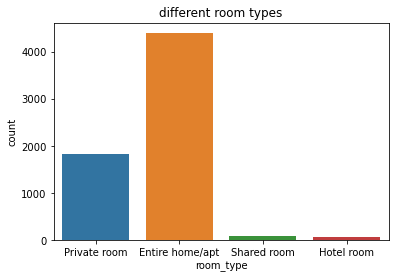

In [ ]:
sns.countplot(x = "room_type", data = dff)
plt.title("different room types")
plt.show()

In [ ]:
# room_type and neighbourhood are categorical variables. We need to quantify them.
# room_type
room_labels = pd.get_dummies(dff['room_type'])

final_data = pd.concat([dff, room_labels], axis=1)#dff.drop(columns=['room_type'])

#  Neighbourhood
safety_score = pd.read_csv('score.txt')
final = final_data.merge(safety_score,on=["neighbourhood"])

airbnb_data = final.sample(random_state=1, frac=1).reset_index()
airbnb_data.pop("index")

# rearange columns
airbnb = airbnb_data.reindex(columns= ['id', 'neighbourhood', 'neighbourhood_score', 'Entire home/apt', 'Hotel room', 'Private room',
                                        'Shared room', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'price'])

airbnb.dropna()

# This the final data cleaned
airbnb.head(100)

,id,neighbourhood,neighbourhood_score,Entire home/apt,Hotel room,Private room,Shared room,minimum_nights,number_of_reviews,reviews_per_month,price
0,39754872,Near North Side,73,1,0,0,0,1,5,0.48,50
1,14382622,Woodlawn,52,1,0,0,0,30,1,0.03,64
2,18769456,Woodlawn,52,1,0,0,0,2,60,1.48,50
3,35459852,Douglas,51,1,0,0,0,2,9,0.66,327
4,15867158,Near North Side,73,1,0,0,0,3,27,0.58,175
...,...,...,...,...,...,...,...,...,...,...,...
95,44433063,Lincoln Park,90,1,0,0,0,3,2,2.00,271
96,40753273,Near North Side,73,0,0,1,0,25,0,NaN,48
97,25481520,Jefferson Park,88,1,0,0,0,1,96,3.42,100
98,41748592,South Shore,50,0,0,1,0,35,0,NaN,44


#### Pair plots

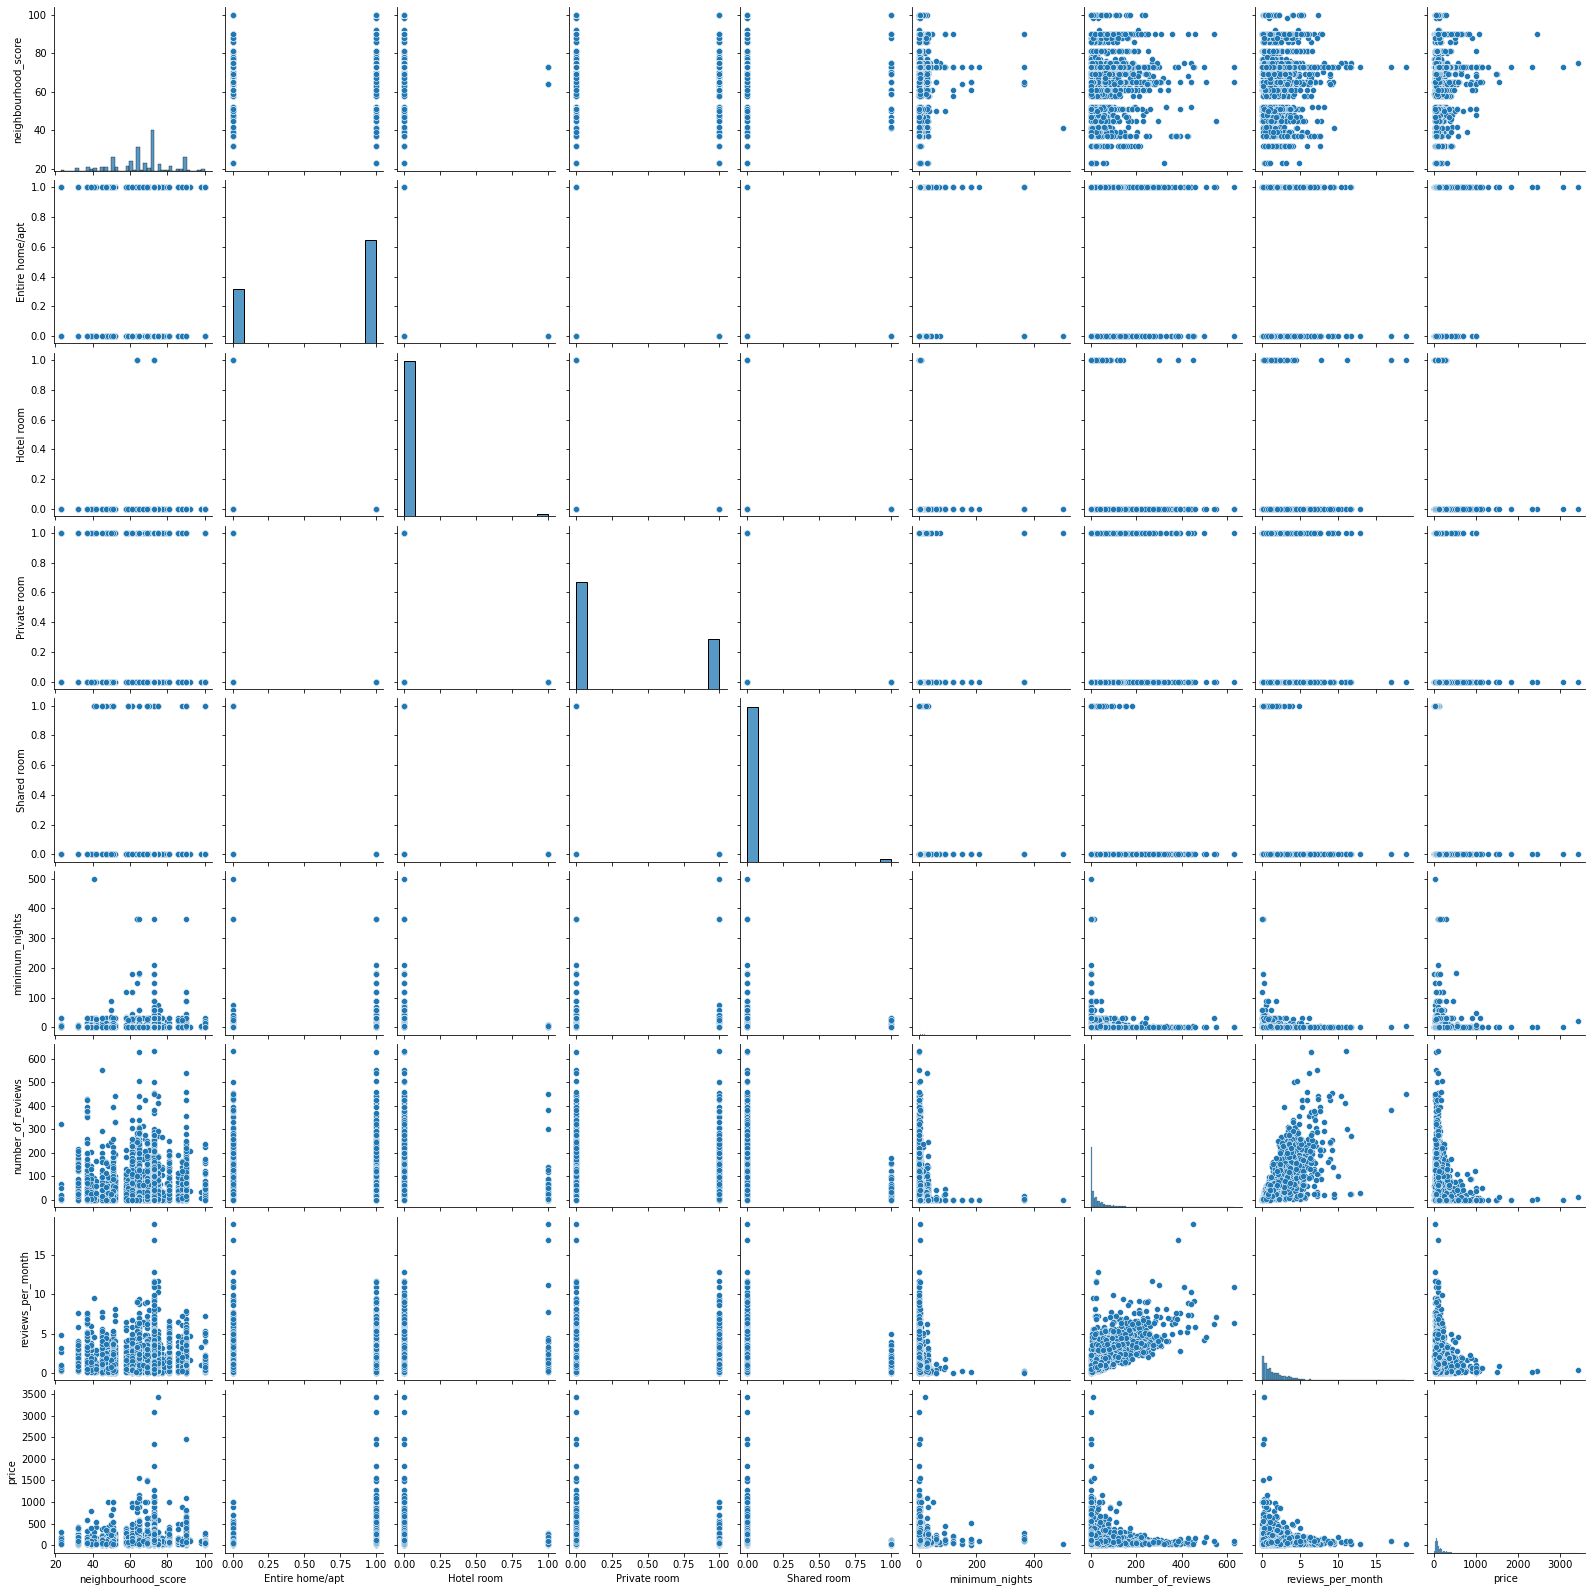

In [ ]:
# create pairs plot for all numeric variables to study the coorelations
# between the features and the label (price)
sns.pairplot(airbnb.drop(columns=['id']))

In [ ]:
# There is a clear coorelation between the two features number_of_reviews and reviews_per_month.
# We will not use one of them as it would be statisticall insignificant to keep them both.

In [ ]:
# Scaling the price.
#airbnb['price'] = airbnb['price'].apply(lambda x: x/mean_price)
a = airbnb[airbnb['price'] > 500].index
airbnb.drop(a, inplace=True)

In [ ]:
b = airbnb[airbnb['number_of_reviews'] == 0].index
airbnb.drop(b , inplace=True)
mean_price = airbnb["price"].mean()
airbnb['price'] = airbnb['price'].apply(lambda x: x/mean_price)
# create the feature list and the label list
X = airbnb.drop(columns = ['id', 'price', 'reviews_per_month','neighbourhood']).to_numpy().reshape(-1, 7)
y = airbnb['price'].to_numpy()

### Construction of the train, validation and test sets.

In [ ]:
# Split the data into train and test sets.
X_model, X_test, y_model, y_test = train_test_split(X, y, test_size=0.15)
X_train, X_val, y_train, y_val = train_test_split(X_model, y_model, test_size=0.25)

In [ ]:
# Cross validation
def cross_validation(model):
    cv_results = cross_validate(model, X, y,
                            cv=10, scoring="neg_mean_squared_error",
                            return_train_score=True,
                            return_estimator=True)
    train_error = -cv_results["train_score"]
    tesr_error = -cv_results["test_score"]
    return train_error, tesr_error

## ML methods

#### Method 1 : Polynomial regression

Text(0.5, 1.0, 'Polynomial regression')

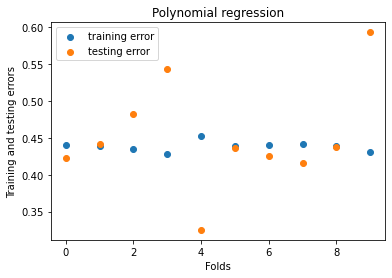

In [ ]:
# Cross validation to test the model on diffrent sets
# we will use the Ridge regularization to prevent overfitting
linear_reg = make_pipeline(PolynomialFeatures(degree=2),Ridge(alpha=0.2))

sets = [0,1,2,3,4,5,6,7,8,9]
train_error, test_error = cross_validation(linear_reg)
plt.scatter(sets, train_error)
plt.scatter(sets, test_error)
plt.xlabel("Folds")
plt.ylabel("Training and testing errors")
plt.legend(["training error", "testing error"], loc ="upper left")
plt.title("Polynomial regression")


In [ ]:
# polynomial regression
poly = PolynomialFeatures(2)
poly_features = poly.fit_transform(X_train)
poly_reg_model = LinearRegression()
poly_reg_model.fit(poly_features, y_train)
y_pred_training = poly_reg_model.predict(poly_features)
y_pred_testing = poly_reg_model.predict(poly.fit_transform(X_val))
training_error = mean_squared_error(y_train, y_pred_training)
testing_error = mean_squared_error(y_val, y_pred_testing)
print("Training error: ", training_error)
print("Testing erro: ", testing_error)

Training error:  0.4452371786022417
Testing erro:  0.4105897124642374


#### Method 2 : MLP (Multi-layer Perceptron) Regression

In [ ]:
layers = [1,2,4,6,8,10]    # number of hidden layers
num_neurons = 15  # number of neurons in each layer

tr_errors_deep = []
val_errors_deep = []

for i, j in enumerate(layers):
    hidden_layer_sizes = tuple([num_neurons]*j)
    deep_reg = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes,random_state=42, max_iter=1000)
    deep_reg.fit(X_train, y_train)

    y_pred_train = deep_reg.predict(X_train)
    y_pred_val = deep_reg.predict(X_val)

    train_error = mean_squared_error(y_train, y_pred_train)
    val_error = mean_squared_error(y_val, y_pred_val)

    tr_errors_deep.append(train_error)
    val_errors_deep.append(val_error)

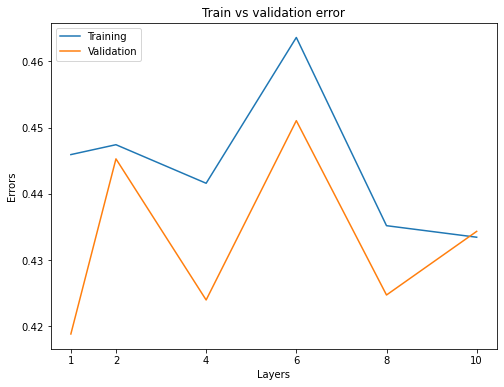

In [ ]:
plt.figure(figsize=(8, 6))

plt.plot(layers, tr_errors_deep, label = 'Training')
plt.plot(layers, val_errors_deep,label = 'Validation')
plt.xticks(layers)
plt.legend(loc = 'upper left')

plt.xlabel('Layers')
plt.ylabel('Errors')
plt.title('Train vs validation error')
plt.show()

In [ ]:
# create a table to compare the training and validation errors for MLPs with different number of hidden layers
errors = {"num_hidden_layers":layers,
          "mlp_train_errors":tr_errors_deep,
          "mlp_val_errors":val_errors_deep,
          "diffrence of errors": abs(np.array(tr_errors_deep) - np.array(val_errors_deep))
         }
pd.DataFrame(errors)

,num_hidden_layers,mlp_train_errors,mlp_val_errors,diffrence of errors
0,1,0.445917,0.418820,0.027097
1,2,0.447410,0.445271,0.002139
2,4,0.441586,0.423955,0.017631
3,6,0.463610,0.451040,0.012569
4,8,0.435178,0.424708,0.010471
5,10,0.433435,0.434319,0.000884


##### we choose layer = 2

In [ ]:
# Cross validation to test the second model on diffrent sets
mlp_deep_regr = make_pipeline(MLPRegressor(hidden_layer_sizes=2,random_state=42, max_iter=1000))

train_mlp, test_mlp = cross_validation(mlp_deep_regr)

Text(0.5, 1.0, 'MLP (layer = 2), training and testing errors')

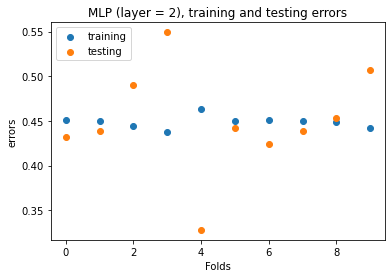

In [ ]:
plt.scatter(sets, train_mlp)
plt.scatter(sets, test_mlp)
plt.xlabel("Folds")
plt.ylabel("errors")
plt.legend(["training", "testing"], loc ="upper left")
plt.title("MLP (layer = 2), training and testing errors")

## Comparing the two models

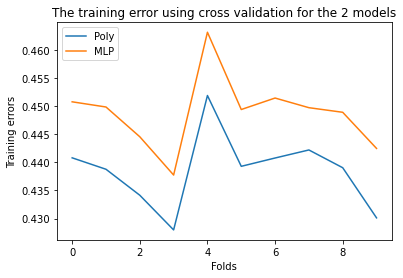

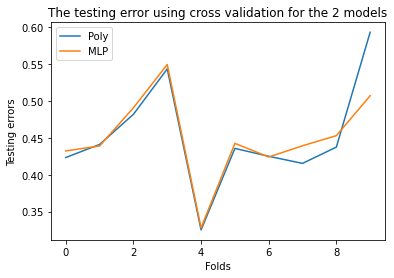

In [ ]:
# Plot the training and testing errors for both models

mlp_train_errors, mlp_test_errors = cross_validation(mlp_deep_regr)
poly_train_errors, poly_test_errors = cross_validation(linear_reg)

sets = [0,1,2,3,4,5,6,7,8,9]
plt.plot(sets, poly_train_errors)
plt.plot(sets, mlp_train_errors)
plt.xlabel("Folds")
plt.ylabel("Training errors")
plt.legend(["Poly", "MLP"], loc ="upper left")
plt.title("The training error using cross validation for the 2 models")
plt.show()

plt.plot(sets, poly_test_errors)
plt.plot(sets, mlp_test_errors)
plt.xlabel("Folds")
plt.ylabel("Testing errors")
plt.legend(["Poly", "MLP"], loc ="upper left")
plt.title("The testing error using cross validation for the 2 models")
plt.show()

### time complexity


In [ ]:
# Compute the time it takes for both models.

t1_mlp = timeit.default_timer()
mlp = MLPRegressor(hidden_layer_sizes=2,random_state=42, max_iter=1000)
mlp.fit(X_train, y_train)
t2_mlp = timeit.default_timer()


t1_poly = timeit.default_timer()
poly = PolynomialFeatures(2)
poly_features = poly.fit_transform(X_train)
poly_reg_model = LinearRegression()
poly_reg_model.fit(poly_features, y_train)
t2_poly = timeit.default_timer()


print('time of execution for the mlp model ', t2_mlp - t1_mlp)
print('time of execution for the plonomial model ', t2_poly - t1_poly)

time of execution for the mlp model  2.2433163999999977
time of execution for the plonomial model  0.0033956999999986692


### Akaike’s Information Criterion (AIC) by (Akaike 1969)

In [ ]:
def AIC(nbr_of_params,ntrain,MSE):
    return ntrain*np.log(MSE) + 2*nbr_of_params

poly = PolynomialFeatures(2)
poly_features = poly.fit_transform(X_train)
poly_reg_model = LinearRegression()
poly_reg_model.fit(poly_features, y_train)
y_pred_training = poly_reg_model.predict(poly_features)
MSE_poly = mean_squared_error(y_train, y_pred_training)


mlp = MLPRegressor(hidden_layer_sizes=2,random_state=42, max_iter=1000)
mlp.fit(X_train, y_train)
y_pred_training = mlp.predict(X_train)
MSE_mlp = mean_squared_error(y_train, y_pred_training)
mlp_params = (len(X_train)*15 + 15*15 + 15*1) + (15 + 15 + 1) # 15 is the number of neurons in every layer and we have 2 layers

# the polynomial model
print("the AIC for the mlp model is :", AIC(mlp_params,len(X_train), MSE_mlp))
print("the AIC for the polynomial model is :", AIC(3,len(X_train), MSE_poly))

the AIC for the mlp model is : 71526.13551323663
the AIC for the polynomial model is : -2032.5138724875526


### Testing the better model on the test set.


In [ ]:
#
poly = PolynomialFeatures(2)
poly_features = poly.fit_transform(X_test)
poly_reg_model = LinearRegression()
poly_reg_model.fit(poly_features, y_test)
y_pred_test = poly_reg_model.predict(poly_features)
MSE_poly = mean_squared_error(y_test, y_pred_test)

In [ ]:
MSE_poly

0.4368053210067403